## Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<hr>

## tar_image_subset exploration

In [2]:
images = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy')
print(images.shape)

(20000, 6, 28)


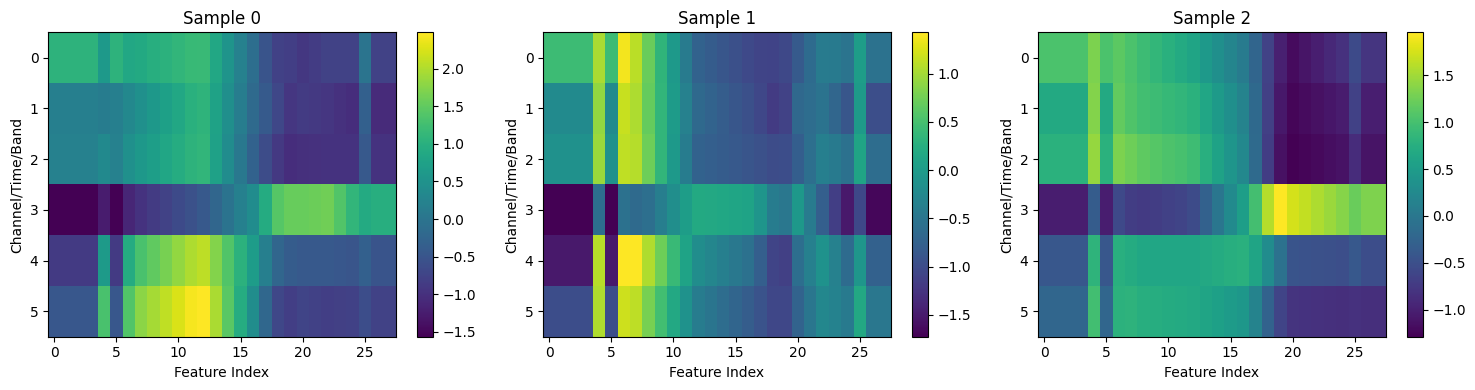

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(images[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

plt.tight_layout()
plt.show()

In [4]:
channel_means = images.mean(axis=(0, 2))  # average over samples and features
channel_stds = images.std(axis=(0, 2))

for i, (m, s) in enumerate(zip(channel_means, channel_stds)):
    print(f"Channel {i}: Mean = {m:.4f}, Std = {s:.4f}")


# Compute overall mean and std
mean = images.mean()
std = images.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")

Channel 0: Mean = 0.0045, Std = 0.9992
Channel 1: Mean = 0.0050, Std = 0.9995
Channel 2: Mean = 0.0040, Std = 1.0005
Channel 3: Mean = 0.0018, Std = 1.0008
Channel 4: Mean = 0.0012, Std = 1.0003
Channel 5: Mean = 0.0017, Std = 1.0009

Global Mean: 0.0030
Global Std Dev: 1.0002


<hr>

## label_target_subset exploration

In [5]:
labels = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')
print(labels.shape)

(20000,)


In [6]:
unique_labels, counts = np.unique(labels, return_counts=True)
total = counts.sum()

print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

Label     Count     Percentage
------------------------------
0         9081      45.41%
1         2603      13.01%
2         8316      41.58%

Total samples: 20000


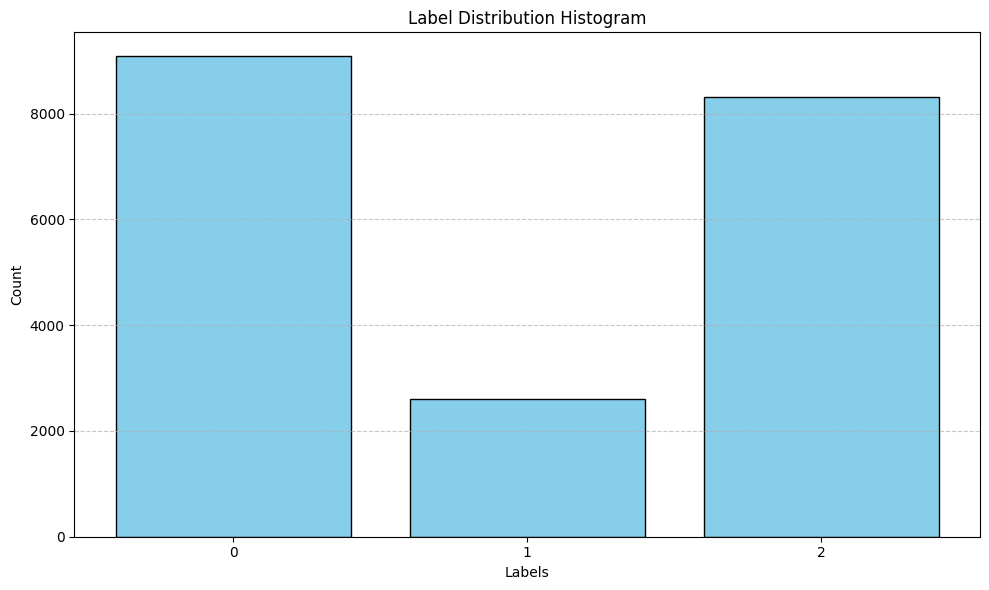

In [7]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution Histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<hr>

## backboneSiteA2019 exploration

In [8]:
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
print(type(backbone_state))
print('\n', backbone_state.keys())

<class 'collections.OrderedDict'>

 odict_keys(['module.conv1.0.weight', 'module.conv1.0.bias', 'module.conv1.1.weight', 'module.conv1.1.bias', 'module.conv1.1.running_mean', 'module.conv1.1.running_var', 'module.conv1.1.num_batches_tracked', 'module.conv2.0.weight', 'module.conv2.0.bias', 'module.conv2.1.weight', 'module.conv2.1.bias', 'module.conv2.1.running_mean', 'module.conv2.1.running_var', 'module.conv2.1.num_batches_tracked', 'module.conv3.0.weight', 'module.conv3.0.bias', 'module.conv3.1.weight', 'module.conv3.1.bias', 'module.conv3.1.running_mean', 'module.conv3.1.running_var', 'module.conv3.1.num_batches_tracked', 'module.conv4.0.weight', 'module.conv4.0.bias', 'module.conv4.1.weight', 'module.conv4.1.bias', 'module.conv4.1.running_mean', 'module.conv4.1.running_var', 'module.conv4.1.num_batches_tracked', 'module.conv5.0.weight', 'module.conv5.0.bias', 'module.conv5.1.weight', 'module.conv5.1.bias', 'module.conv5.1.running_mean', 'module.conv5.1.running_var', 'module.conv5.1

-> So, we can see from this that the model from which the preprocessed image feature maps are extracted is a simple 1D cnn model with 5 conv layers, each followed by a batch norm layer.

In [9]:
for k, v in backbone_state.items():
    print(f"{k:40} → {v.shape}")

module.conv1.0.weight                    → torch.Size([64, 6, 5])
module.conv1.0.bias                      → torch.Size([64])
module.conv1.1.weight                    → torch.Size([64])
module.conv1.1.bias                      → torch.Size([64])
module.conv1.1.running_mean              → torch.Size([64])
module.conv1.1.running_var               → torch.Size([64])
module.conv1.1.num_batches_tracked       → torch.Size([])
module.conv2.0.weight                    → torch.Size([128, 64, 5])
module.conv2.0.bias                      → torch.Size([128])
module.conv2.1.weight                    → torch.Size([128])
module.conv2.1.bias                      → torch.Size([128])
module.conv2.1.running_mean              → torch.Size([128])
module.conv2.1.running_var               → torch.Size([128])
module.conv2.1.num_batches_tracked       → torch.Size([])
module.conv3.0.weight                    → torch.Size([256, 128, 5])
module.conv3.0.bias                      → torch.Size([256])
module.conv3.1.

<hr>

## fcSiteA2019.pth

In [10]:
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')
print(type(fc_state))
print('\n', fc_state.keys())

<class 'collections.OrderedDict'>

 odict_keys(['module.fco.weight', 'module.fco.bias'])


In [11]:
for k, v in fc_state.items():
    print(f"{k:40} → {v.shape}")

module.fco.weight                        → torch.Size([3, 1024])
module.fco.bias                          → torch.Size([3])


<hr>

## Re-creating the Architecture

In [15]:
################ CNN Backbone
def conv_block(in_channels: int, out_channels: int) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
    )
 
 
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)

        self.global_pool = nn.AdaptiveAvgPool1d((1))
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
 
        x=self.global_pool(x)

        x = x.view(x.size(0), -1)

        return x
 
 
################ Fully connected network
class FC(nn.Module):
    def __init__(self,input_dim):
        super(FC, self).__init__()
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x=self.fco(x)
        return x

In [16]:
# Remove DataParallel prefixes
from collections import OrderedDict
backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

for k, v in backbone_state.items():
    print(f"{k:40} → {v.shape}")

conv1.0.weight                           → torch.Size([64, 6, 5])
conv1.0.bias                             → torch.Size([64])
conv1.1.weight                           → torch.Size([64])
conv1.1.bias                             → torch.Size([64])
conv1.1.running_mean                     → torch.Size([64])
conv1.1.running_var                      → torch.Size([64])
conv1.1.num_batches_tracked              → torch.Size([])
conv2.0.weight                           → torch.Size([128, 64, 5])
conv2.0.bias                             → torch.Size([128])
conv2.1.weight                           → torch.Size([128])
conv2.1.bias                             → torch.Size([128])
conv2.1.running_mean                     → torch.Size([128])
conv2.1.running_var                      → torch.Size([128])
conv2.1.num_batches_tracked              → torch.Size([])
conv3.0.weight                           → torch.Size([256, 128, 5])
conv3.0.bias                             → torch.Size([256])
conv3.1.weight 

In [20]:
# Initialize and load models
backbone = cnn()
backbone.to(device)

fc = FC(1024)
fc.to(device)

backbone.load_state_dict(backbone_state)
fc.load_state_dict(fc_state)

<All keys matched successfully>

In [21]:
backbone.eval()
fc.eval()

# Run inference on one sample
sample = torch.tensor(images[0], dtype=torch.float32).unsqueeze(0).to(device)  # (1, 6, 28)
features = backbone(sample)  # (1, 1024)
output = fc(features)        # (1, 3)
probs = torch.softmax(output, dim=1)
print("Probabilities:", probs.cpu().detach().numpy())
print("Predicted class:", torch.argmax(output, dim=1).item())
print("Actual class:", labels[0])

Probabilities: [[7.3489809e-06 3.2383460e-04 9.9966884e-01]]
Predicted class: 2
Actual class: 0


<hr>

## Evaluation

In [22]:
def eval_perf(dataloader, backbone, fc, device):
    backbone.eval()
    fc.eval()

    pred=[]
    gt=[]

    with torch.no_grad():
        for batch in dataloader:
            xt, yt = batch["x"].to(device), batch["y"].to(device)

            # Forward pass through backbone and FC head
            features = backbone(xt)
            outputs = fc(features)
            
            yt_pred = torch.argmax(outputs, dim=1)
            pred.extend(yt_pred.cpu().numpy())
            gt.extend(yt.cpu().numpy())

    # Convert to numpy arrays
    pred = np.array(pred)
    gt = np.array(gt)

    # Computing metrics
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    acc = np.mean(pred == gt)
    avg_f1 = f1s.mean()

    # Set models back to train mode
    backbone.train()
    fc.train()

    return f1s, acc, avg_f1

<hr>

## Dataset and Dataloader

In [26]:
class SimpleDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])  # shape: (6, 28)
        y = torch.tensor(self.labels[idx])
        return {"x": x, "y": y}

In [27]:
dataset = SimpleDataset(images, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [30]:
f1s, acc, avg_f1 = eval_perf(dataloader, backbone, fc, device)

print("Per-class F1 scores:", f1s)
print(f"Overall Accuracy: {acc * 100:.2f}%")
print(f"Average F1 Score: {avg_f1:.4f}")

Per-class F1 scores: [0.46723044 0.54708171 0.66883978]
Overall Accuracy: 57.38%
Average F1 Score: 0.5611


<hr>

<hr>